In [10]:
# Importing the Keras libraries and packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from tensorflow.keras.optimizers import SGD
print (tf.__version__)

2.7.0


#  DATA PREPROCESSING


In [2]:
!git clone https://github.com/cptdtbk/Datasets
%cd /content/Datasets/FB_stock_price/

Cloning into 'Datasets'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 357 (delta 12), reused 0 (delta 0), pack-reused 329
Receiving objects: 100% (357/357), 297.08 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Checking out files: 100% (207/207), done.
/content/Datasets/FB_stock_price


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
dataset_train = pd.read_csv('FB_train.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [5]:
pd.DataFrame(training_set)

,0
0,42.049999
1,36.529999
2,32.610001
3,31.370001
4,32.950001
...,...
2165,268.880005
2166,268.739990
2167,276.950012
2168,277.950012


In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
print(X_train.shape, y_train.shape)

(2110, 60, 1) (2110,)


#Simple RNN 

##Build model

In [11]:
model1 = Sequential()
# Adding the first RNN layer and some Dropout regularisation
model1.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model1.add(Dropout(0.2))
# Adding a second RNN layer and some Dropout regularisation.
model1.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True))
model1.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
model1.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True))
model1.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
model1.add(SimpleRNN(units = 50))
model1.add(Dropout(0.2))

# Adding the output layer
model1.add(Dense(units = 1))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [12]:
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

##Train 

In [13]:
# Fitting the RNN to the Training set
history = model1.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
66/66 [==============================] - 28s 300ms/step - loss: 0.3484
Epoch 2/100
66/66 [==============================] - 18s 270ms/step - loss: 0.1782
Epoch 3/100
66/66 [==============================] - 18s 266ms/step - loss: 0.1125
Epoch 4/100
66/66 [==============================] - 23s 349ms/step - loss: 0.0773
Epoch 5/100
66/66 [==============================] - 18s 266ms/step - loss: 0.0489
Epoch 6/100
66/66 [==============================] - 18s 273ms/step - loss: 0.0347
Epoch 7/100
66/66 [==============================] - 18s 274ms/step - loss: 0.0261
Epoch 8/100
66/66 [==============================] - 17s 261ms/step - loss: 0.0217
Epoch 9/100
66/66 [==============================] - 17s 262ms/step - loss: 0.0180
Epoch 10/100
66/66 [==============================] - 18s 270ms/step - loss: 0.0139
Epoch 11/100
66/66 [==============================] - 19s 287ms/step - loss: 0.0124
Epoch 12/100
66/66 [==============================] - 18s 265ms/step - loss: 0.0103
E

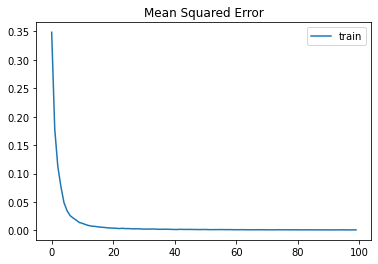

In [14]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

##Evaluation

In [15]:
# Getting the real stock price of 2021
dataset_test = pd.read_csv('FB_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [16]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #getting input of each previous financial days
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [17]:
from sklearn.metrics import mean_squared_error as mse, r2_score
print("MSE:" ,mse(real_stock_price,predicted_stock_price))
print("R2_score:",r2_score(real_stock_price,predicted_stock_price))

MSE: 320.82383860433055
R2_score: 0.7352532201285517


## Visualize results


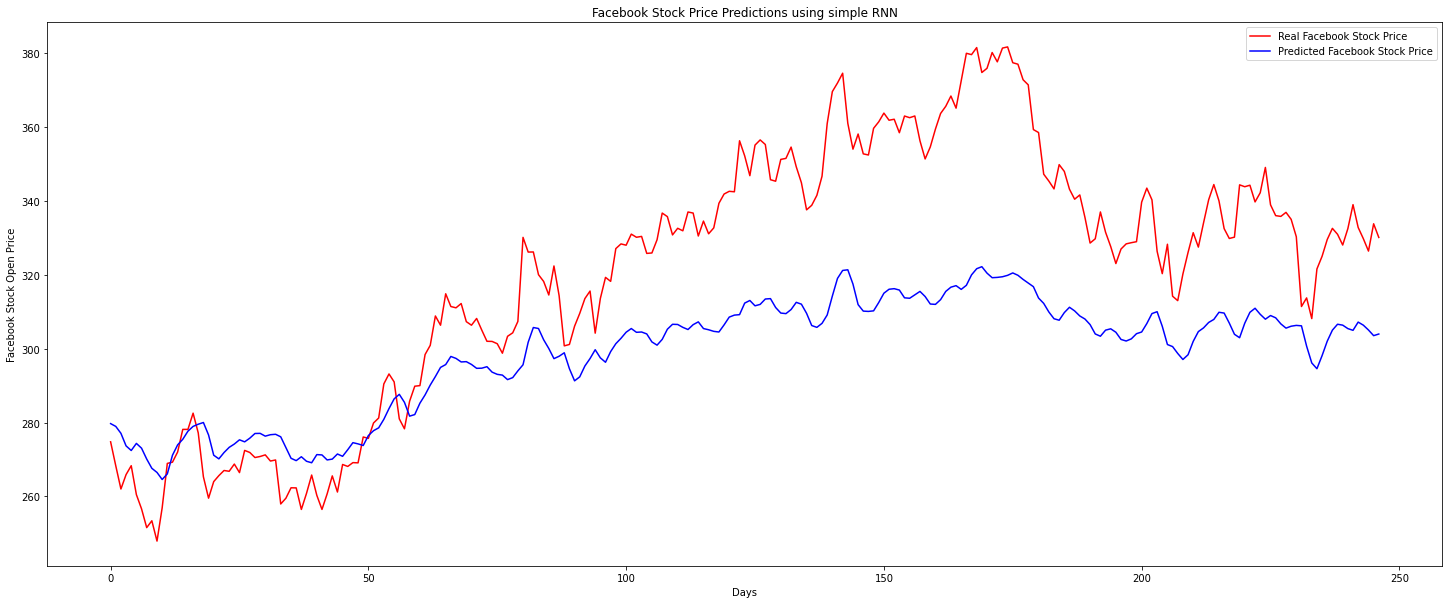

In [ ]:
# Visualising the results
plt.figure(figsize = (25,10))
plt.plot(real_stock_price, color = 'red', label = 'Real Facebook Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Facebook Stock Price')
plt.title('Facebook Stock Price Predictions using simple RNN')
plt.xlabel('Days')
plt.ylabel('Facebook Stock Open Price')
plt.legend()
plt.show()

#LSTM 

##Build model

In [18]:
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#regressor.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [ ]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

##Train

In [19]:
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
66/66 [==============================] - 12s 63ms/step - loss: 0.0161
Epoch 2/100
66/66 [==============================] - 4s 65ms/step - loss: 0.0035
Epoch 3/100
66/66 [==============================] - 4s 64ms/step - loss: 0.0033
Epoch 4/100
66/66 [==============================] - 4s 61ms/step - loss: 0.0029
Epoch 5/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0025
Epoch 6/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0025
Epoch 7/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0024
Epoch 8/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0026
Epoch 9/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0025
Epoch 10/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0022
Epoch 11/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0022
Epoch 12/100
66/66 [==============================] - 4s 60ms/step - loss: 0.0018
Epoch 13/100
66/66 [====

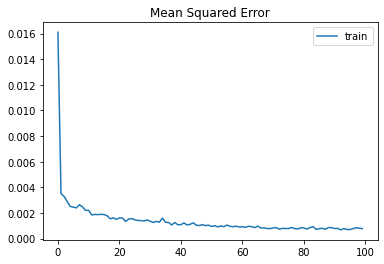

In [20]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

##Evaluation

In [21]:
# Getting the real stock price of 2021
dataset_test = pd.read_csv('FB_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [22]:
# Getting the predicted stock price of 2021
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [23]:
#evaluating
from sklearn.metrics import mean_squared_error as mse, r2_score
print("MSE:" ,mse(real_stock_price,predicted_stock_price))
print("R2_score:",r2_score(real_stock_price,predicted_stock_price))

MSE: 99.79680092054579
R2_score: 0.9176467627838243


##Visualize results

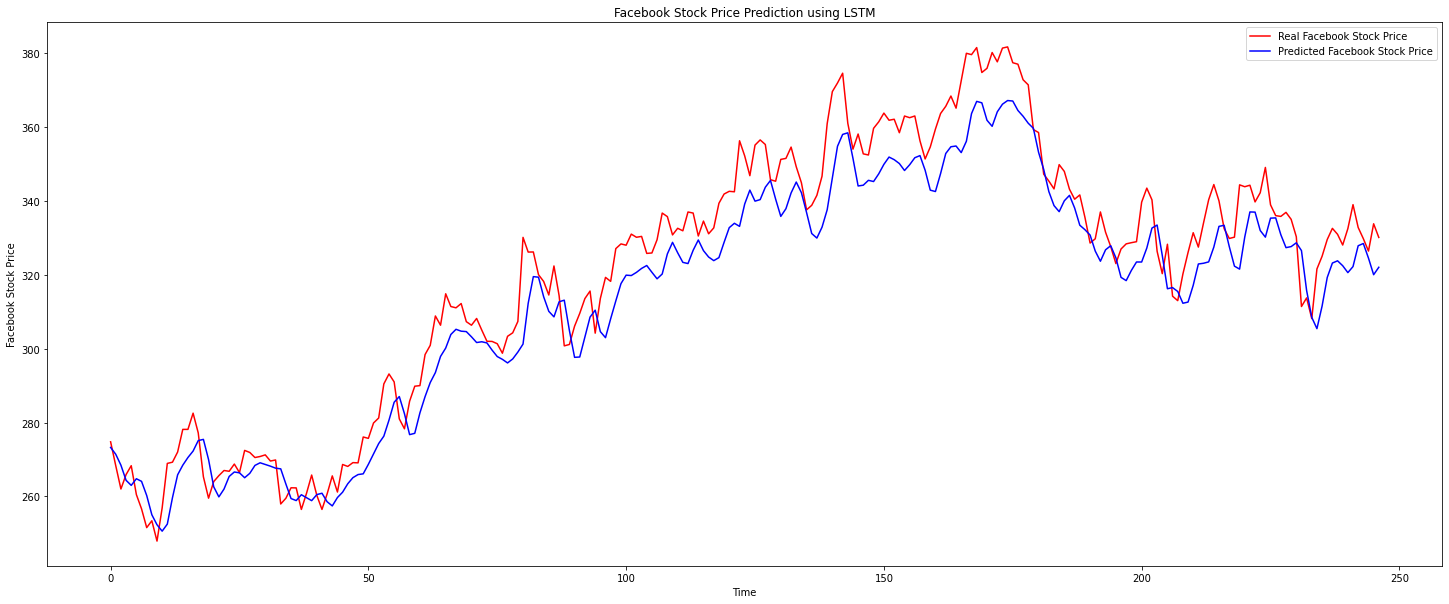

In [24]:
plt.figure(figsize = (25,10))
plt.plot(real_stock_price, color = 'red', label = 'Real Facebook Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Facebook Stock Price')
plt.title('Facebook Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.show()

#GRU 

##Build model

In [25]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units = 1))
# Compiling the RNN
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error')

##Train

In [26]:
# Fitting the RNN to the Training set
history = regressorGRU.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
66/66 [==============================] - 11s 58ms/step - loss: 0.0182
Epoch 2/100
66/66 [==============================] - 4s 58ms/step - loss: 0.0032
Epoch 3/100
66/66 [==============================] - 4s 59ms/step - loss: 0.0025
Epoch 4/100
66/66 [==============================] - 4s 58ms/step - loss: 0.0023
Epoch 5/100
66/66 [==============================] - 4s 61ms/step - loss: 0.0021
Epoch 6/100
66/66 [==============================] - 4s 62ms/step - loss: 0.0022
Epoch 7/100
66/66 [==============================] - 4s 62ms/step - loss: 0.0020
Epoch 8/100
66/66 [==============================] - 4s 64ms/step - loss: 0.0024
Epoch 9/100
66/66 [==============================] - 4s 61ms/step - loss: 0.0020
Epoch 10/100
66/66 [==============================] - 4s 64ms/step - loss: 0.0019
Epoch 11/100
66/66 [==============================] - 4s 62ms/step - loss: 0.0018
Epoch 12/100
66/66 [==============================] - 4s 62ms/step - loss: 0.0016
Epoch 13/100
66/66 [====

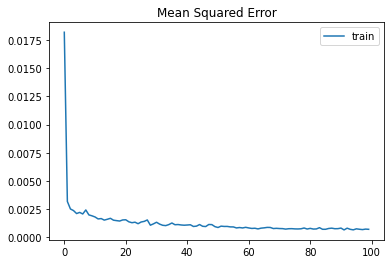

In [27]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

##Evaluation

In [28]:
# Getting the real stock price of 2021
dataset_test = pd.read_csv('FB_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [29]:
# Getting the predicted stock price of 2021
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [30]:
#evaluating
from sklearn.metrics import mean_squared_error as mse, r2_score
print("MSE:", mse(real_stock_price,predicted_stock_price))
print("R2_score:", r2_score(real_stock_price,predicted_stock_price))

MSE: 291.8749569749977
R2_score: 0.7591421032788392


##Visualize results

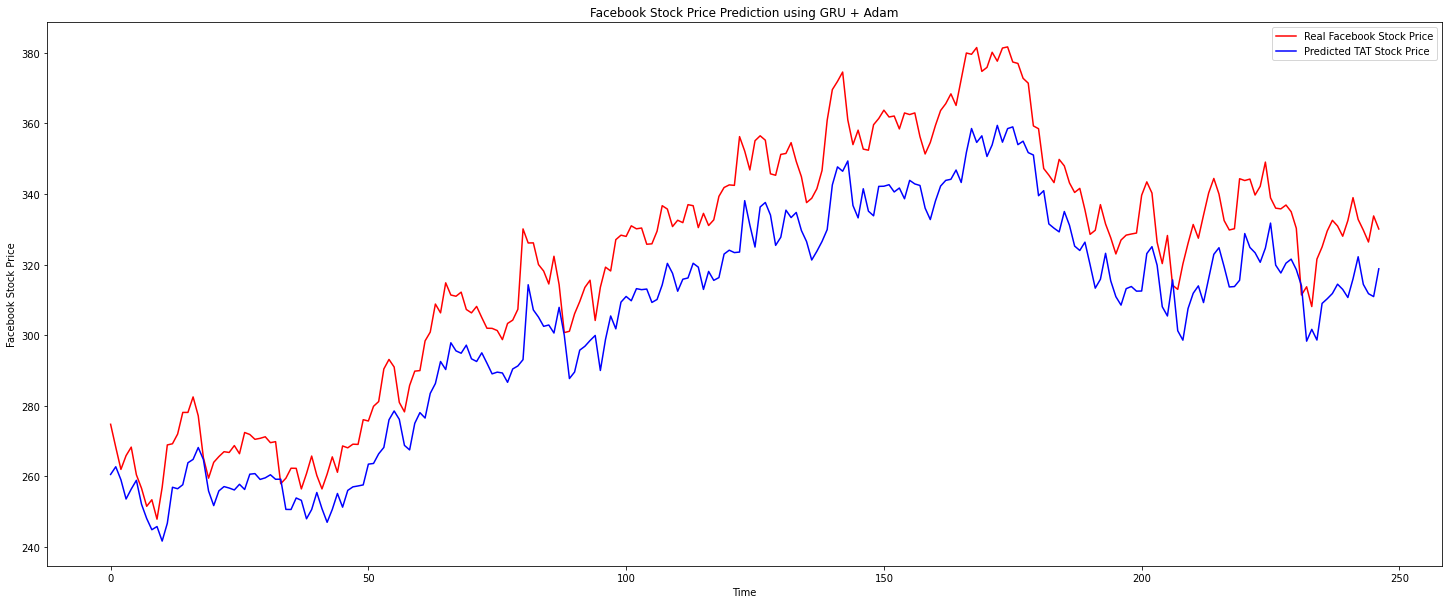

In [31]:
# Visualising the results
plt.figure(figsize = (25,10))
plt.plot(real_stock_price, color = 'red', label = 'Real Facebook Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TAT Stock Price')
plt.title('Facebook Stock Price Prediction using GRU + Adam')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.show()